**CS-401 Applied Data Analysis**  
**Project Milestone 2** 

**Group ID:** TheSuricates  

# **Budget Battles:** Maximizing Returns in Filmmaking Odyssey

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from helpers import *

PATH = './data'

### Import CMU dataset

We import the CMU data and add the names of the columns by looking at the data documentation.

In [2]:
data_folder = './data/'

character = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', 
                        names=['wikiPageID', 'freebaseMovieId', 'DateOfRelease', 'characterName', 'actorDOB',
                               'actorGender', 'actorHeight', 'actorEthnicity', 'actorName', 
                               'actorAge', 'map1', 'map2', 'map3'])

movie = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', 
                    names=['wikiPageID', 'freebaseMovieId', 'movieName', 'movieReleaseDate', 'movieBoxOfficeRevenue',
                            'movieRuntime', 'movieLanguages', 'movieCountries', 'movieGenres'])

## Merging additional dataset

Our initial data does not contain information about the **budget** of the movie. We will then use wikidata and merge it to our dataset. Before merging we preprocess the data and make a currency convertion to have all the values in **USD**.

#### Data Preprocessing and Currency Converion

In [ ]:
# Read the data into a DataFrame
df = pd.read_csv(f"{PATH}/film_wiki_data.csv")

# Group by 'filmLabel' and keep the row with the max 'boxOffice' for each group since some films have multiple rows with box office per country
df = df.loc[df.groupby('filmLabel')['boxOffice'].idxmax()]
df = df.reset_index(drop=True)

# Apply the currency conversion to each row
df = df.apply(lambda row: convert_row_currency(PATH, row), axis=1)

# remove if page id is not defined
df = df[df['wikiPageID'] != -1]
# save csv without row index
df.to_csv(f'{PATH}/film_wiki_data_formatted.csv', index=False)

#### Merge Datasets

In [283]:
# Load the Wikidata CSV file
wiki_data = pd.read_csv(f'{PATH}/film_wiki_data_formatted.csv')

# Merge the Wikidata CSV file with the movie metadata CSV file
merged_movie = pd.merge(wiki_data, movie, on='wikiPageID', how='inner')
merged_movie.to_csv(f'{PATH}/merged_movie_data.csv', index=False)

print('There are {} movies in the merged dataset'.format(len(merged_movie)))

There are 810 movies in the merged dataset


We observe that only 810 movies match the Wikidata dataset. We will determine if this is sufficient or if we need to add TMDB data to enhance the dataset.

# Cleaning data

We will first remove all the *missing values* in the features we will use. 
As we need information about both the **movie** and the **characters** in it for our analysis, we will keep only the rows which are common in both movie and character dataframes. 

In [284]:
# Remove rows in the movie dataframe containing NaNs on features we will use
cleaned_movie = merged_movie.copy()
cleaned_movie.dropna(subset=['cost', 'boxOffice', 'movieReleaseDate', 'movieRuntime',
                              'movieCountries', 'movieGenres'], inplace=True)

# Remove rows in the character dataframe without actor names
cleaned_character = character.copy()
cleaned_character.dropna(subset=['actorName'], inplace=True)

In [285]:
# Remove rows which are not common in the movie and character dataframes
cleaned_character = cleaned_character[cleaned_character['wikiPageID'].isin(cleaned_movie['wikiPageID'])]
cleaned_movie = cleaned_movie[cleaned_movie['wikiPageID'].isin(cleaned_character['wikiPageID'])]

# Preparing movie features

Let's create our own dataframe with some features which could have an effect on the `multiplier` of the money earned relative to the money invested in the film.

First we will use features which already exist in the movie metadata : the `runtime`, movie `country` and `genre`. We will also need to keep the `wikipedia id`, the `name` of the movie, the `release date` and the `box office` revenue for our analysis.

In [286]:
# Create a new dataframe using movie information
movie_features = cleaned_movie[['wikiPageID', 'movieName', 'movieReleaseDate', 'cost', 'boxOffice',
                                 'movieRuntime', 'movieCountries', 'movieGenres']].copy()
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""..."
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra..."
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


We will also create new features from the character metadata : 
- the `number of characters` per movie
- the `average experience` of actors : the average upon all actors of the number of movies they appear in (before the movie)
- the `male ratio` of actors
- the `ratio of young actors` (below 18 years old)
- the `ratio of old actors` (above 60 years old)

In [287]:
# Total number of characters, number by age category and by gender
counts = cleaned_character.groupby('wikiPageID').agg(
    numberOfCharacters=('actorName', 'size'),
    below18=('actorAge', lambda x: (x < 18).sum()),
    above60=('actorAge', lambda x: (x > 60).sum()),
    maleRatio=('actorGender', lambda x: (x == 'M').sum())
).reset_index()

# We change the number of characters by age/gender by the ratio above total number of characters
counts['below18'] = counts['below18'] / counts['numberOfCharacters']
counts['above60'] = counts['above60'] / counts['numberOfCharacters']
counts['maleRatio'] = counts['maleRatio'] / counts['numberOfCharacters']

# Add the new columns to our movie_features dataframe
movie_features = pd.merge(movie_features, counts, left_on='wikiPageID', right_on='wikiPageID', how='left')
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres,numberOfCharacters,below18,above60,maleRatio
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",13,0.076923,0.000000,0.538462
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",11,0.000000,0.090909,0.636364
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",9,0.000000,0.111111,0.888889
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra...",18,0.055556,0.000000,0.555556
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",15,0.000000,0.000000,0.866667


In [288]:
# Actors' experience
# Sort by the date of release (dor) within each actor group
sorted_character = cleaned_character.sort_values(['actorName', 'DateOfRelease'])

# Calculate cumulative count of movies for each actor up to the current movie
sorted_character['cumulative_movie_count'] = sorted_character.groupby('actorName').cumcount()

# Group by movie (wiki_id) and calculate the mean upon all actors of cumulative movie counts for each movie
experience_per_movie = sorted_character.groupby('wikiPageID')['cumulative_movie_count'].mean().reset_index()
experience_per_movie.columns = ['wikiPageID', 'averageActorsExperience']

# Merge with the 'movie_features' dataframe
movie_features = pd.merge(movie_features, experience_per_movie, on='wikiPageID', how='left')
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres,numberOfCharacters,below18,above60,maleRatio,averageActorsExperience
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",13,0.076923,0.000000,0.538462,0.307692
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",11,0.000000,0.090909,0.636364,0.727273
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",9,0.000000,0.111111,0.888889,0.777778
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra...",18,0.055556,0.000000,0.555556,0.666667
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",15,0.000000,0.000000,0.866667,0.266667


# Separate low and high budget movies

### Removing outliers

First, we will eliminate outliers from our data concerning the `multiplier` between the `cost` and the `boxOffice`. Some multipliers are excessively large, potentially inaccurately reported in Wikidata. To address this, we filter out data below the 2nd quantile and above the 98th quantile. Additionally, we exclude extremely low and excessively high budgets deemed incorrect.

In [289]:
# Create a new column corresponding to the ratio between the revenue and budget of the movie
movie_features['multiplier'] = movie_features['boxOffice'] / movie_features['cost']

outliers = (movie_features['multiplier']  < movie_features['multiplier'].quantile(0.02)) | (movie_features['multiplier']  > movie_features['multiplier'].quantile(0.98))
to_high_budget = 1*10**10
to_low_budget = 1.2*10**4

# Remove outliers from the movie_features dataframe
movie_features_no_outliers = movie_features[(movie_features['multiplier'] != outliers) & (movie_features['cost'] < to_high_budget) & (movie_features['cost'] > to_low_budget)]

In [ ]:
# Convert the movies date of release to datetime
movie_features_no_outliers['movieReleaseDate'] = movie_features_no_outliers['movieReleaseDate'].apply(convert_to_datetime)

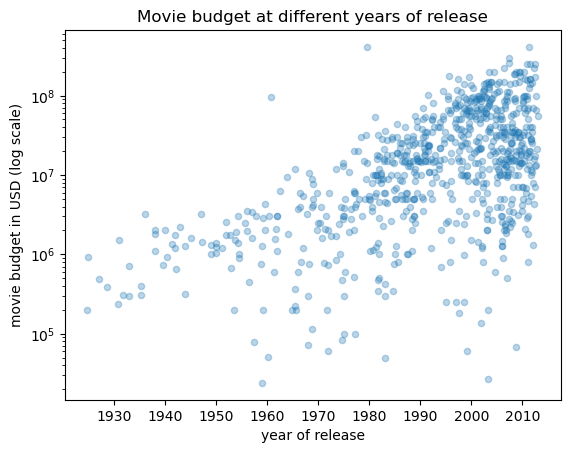

In [291]:
# Plot the movie budget at different years of release
plt.scatter(movie_features_no_outliers['movieReleaseDate'], movie_features_no_outliers['cost'], alpha=0.3, s=20)
plt.title('Movie budget at different years of release')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.show()

### Separate in low and high budget categories

To distinguish between `low` and `high`-budget films, we categorize films into five-year groups based on their release dates. The top 25% of films with the highest budgets and the bottom 25% with the lowest budgets are then identified within each time frame. This process mitigates the impact of ***inflation*** on budget categorization. Subsequently, all high-budget films from different periods will be regrouped into a single high-budget category, and the same will be done for low-budget films.

In [ ]:
min_year = movie_features_no_outliers['movieReleaseDate'].min().year
max_year = movie_features_no_outliers['movieReleaseDate'].max().year

# Create a new column corresponding to the year of release of the movie
movie_features_no_outliers['year'] = movie_features_no_outliers['movieReleaseDate'].dt.year  

df_low_budget_movie = pd.DataFrame(columns=movie_features_no_outliers.columns)
df_high_budget_movie = pd.DataFrame(columns=movie_features_no_outliers.columns)

year = min_year
while year < max_year:
    # Select movies released by 5 years interval
    movies = movie_features_no_outliers[(movie_features_no_outliers['year'] >= int(year)) & (movie_features_no_outliers['year'] < int(year + 5))]
    # Add the movies with the highest and lowest budget to the corresponding dataframe
    df_high_budget_movie = pd.concat([pd.DataFrame(movies[movies['cost'] > movies['cost'].quantile(0.75)]),df_high_budget_movie], ignore_index=True)
    df_low_budget_movie = pd.concat([pd.DataFrame(movies[movies['cost'] < movies['cost'].quantile(0.25)]),df_low_budget_movie], ignore_index=True)
    year += 5


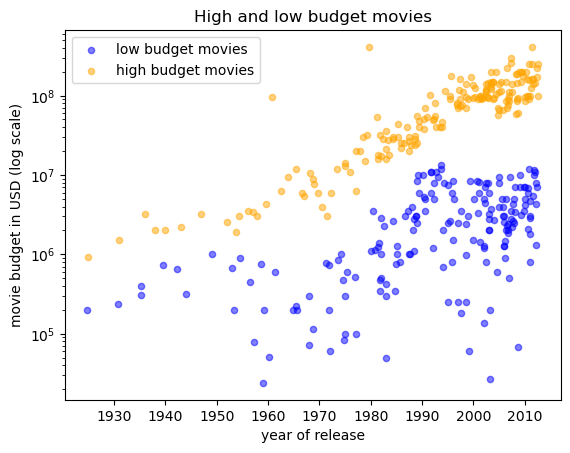

In [293]:
# Plot the high and low budget movies at different years of release
plt.scatter(df_low_budget_movie['movieReleaseDate'], df_low_budget_movie['cost'], label='low budget movies', color='blue', alpha=0.5, s=20)
plt.scatter(df_high_budget_movie['movieReleaseDate'], df_high_budget_movie['cost'], label='high budget movies', color='orange', alpha=0.5, s=20)
plt.title('High and low budget movies')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

We observe a distinct separation between `low` and `high` budgets. The graph illustrates that the definition of low and high budgets changes over the years, following a logarithmic function.
